## Extract DataDog API RUM events for Platform Insights Investigation

In [ ]:
import pandas as pd
import json
import plotly.graph_objects as go
import os

import datadog_api_client
from datadog_api_client import ApiClient, Configuration
from datadog_api_client.v2.api.rum_api import RUMApi
from datadog_api_client.v2.model.rum_query_filter import RUMQueryFilter
from datadog_api_client.v2.model.rum_query_options import RUMQueryOptions
from datadog_api_client.v2.model.rum_query_page_options import RUMQueryPageOptions
from datadog_api_client.v2.model.rum_search_events_request import RUMSearchEventsRequest
from datadog_api_client.v2.model.rum_sort import RUMSort

In [ ]:
configuration = datadog_api_client.v2.Configuration(
    os.getenv('DD_HOST')
)

# Configure API key authorization: apiKeyAuth
configuration.api_key['apiKeyAuth'] = os.getenv('DD_CLIENT_API_KEY')

# Configure API key authorization: appKeyAuth
configuration.api_key['appKeyAuth'] = os.getenv('DD_CLIENT_APP_KEY')


country_list = []
subdivision_list = []
user_list = []
email_list = []
url_list = []
url_query_list = []
loading_type_list = []
timestamp_list = []

### Pull out the fields we are most interested in for analysis purposes

# def parse_response(response_list, country_list, subdivision_list, user_list, email_list, url_list, service_list, timestamp_list):
def parse_response(response_list, country_list, user_list, email_list, url_list, service_list, timestamp_list):

    for item in response_list:
        url_list.append((item.attributes.attributes['view']['url_path']).lower())

        if item.attributes.attributes['view']['url_path'] == '/search' and 'url_query' in item.attributes.attributes['view'].keys():
            url_query_list.append(item.attributes.attributes['view']['url_query']['query'].replace('%20',' '))
        else:
            url_query_list.append(None)

        ## Get user data when available
        if 'usr' in item.attributes.attributes.keys():
            user_list.append(item.attributes.attributes['usr']['id'])
            email_list.append(item.attributes.attributes['usr']['email'])
        else:
            user_list.append('No user data')
            email_list.append('No user data')

        country_list.append(item.attributes.attributes['geo']['country'])
        loading_type_list.append(item.attributes.attributes['view']['loading_type'])
        timestamp_list.append(item.attributes['timestamp'])

    return country_list, user_list, email_list, url_list, url_query_list, loading_type_list, timestamp_list



### Body is set for the request depending on pagination need, cursor is included when next page call is required

def set_body(cursor_value = None):

    from_value = 'now-200d'
    limit_value = 1000

    if cursor_value:
        body = RUMSearchEventsRequest(
            filter=RUMQueryFilter(
                _from=from_value,
                query="@type:view AND @session.type:user AND @application.name:platform-backstage",
                to="now",
            ),
            options=RUMQueryOptions(
                time_offset=0,
                timezone="GMT",
            ),
            page=RUMQueryPageOptions(
                cursor= cursor_value,
                limit=limit_value,
            ),
            sort=RUMSort.TIMESTAMP_ASCENDING,
            )
    else:
        body = RUMSearchEventsRequest(
            filter=RUMQueryFilter(
                _from=from_value,
                query="@type:view AND @session.type:user AND @application.name:platform-backstage",
                to="now",
            ),
            options=RUMQueryOptions(
                time_offset=0,
                timezone="GMT",
            ),
            page=RUMQueryPageOptions(
                limit=limit_value,
            ),
            sort=RUMSort.TIMESTAMP_ASCENDING,
            )        

    return body



### Requests to api client for event data

with ApiClient(configuration) as api_client:
    api_instance = RUMApi(api_client)

    response = api_instance.search_rum_events(body=set_body())
    next_item = response['meta']['page']['after']

    country_list, user_list,email_list, url_list, url_query_list, loading_type_list, timestamp_list = parse_response(response.data, country_list, user_list, email_list, url_list, loading_type_list, timestamp_list)

    while next_item:
        
        response = api_instance.search_rum_events(body=set_body(next_item))
        
        if 'page' in response['meta']:
            next_item = response['meta']['page']['after']
        else:
             next_item = None

        country_list, user_list, email_list, url_list, url_query_list, loading_type_list, timestamp_list = parse_response(response.data, country_list, user_list, email_list, url_list, loading_type_list, timestamp_list)

### Put event data into dataframe
        
all_data = {
    'country': country_list,
    'user_id': user_list,
    'user_email': email_list,
    'url': url_list,
    'url_query': url_query_list,
    'loading_type': loading_type_list, 
    'timestamp': timestamp_list,
}

df = pd.DataFrame.from_dict(all_data)

In [ ]:
df['StartDate'] = df['timestamp'].apply(lambda x: pd.to_datetime(str(x).split(' ')[0]))
df['Week'] = df['StartDate'].apply(lambda x: pd.to_datetime(str(x.to_period('W')).split('/')[0]))
df['Month'] = pd.to_datetime(df['timestamp'].dt.to_period('M').astype(str))
df['Day'] = pd.to_datetime(df['timestamp'].dt.to_period('d').astype(str))

In [ ]:
category_list = []

def process_category(category_column):
    for category in category_column:
        if category == '/':
            cat = 'home'
        elif category == None:
            cat = None
        elif '/' in category:
            cat = category.split('/')[1]
        else:
            cat = category

        category_list.append(cat)
    return category_list

df['category'] = process_category(df['url'])

categories_of_interest = ['docs', 'catalog', 'home', 'create', 'search', 'tech-matrix', 'settings', 'golden-paths', 'catalog-graph', 'catalog-import', 'model-training', 'data-dictionary', 'manual-onboarding']

df = df[df['category'].isin(categories_of_interest)]

In [ ]:
squad_dict = pd.Series(squad_df.Squad.values,index=squad_df.Employee).to_dict()
df['squad'] = df['user_id'].apply(lambda x:  squad_dict[x.upper()] if x.upper() in squad_dict.keys() else 'User not found')

## Plot the summary event data as a pie chart

In [ ]:
summary = df['category'].value_counts().reset_index()

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=summary["category"],
        values=summary["count"],
        texttemplate="%{label}<br>"
                     "%{percent:.1%} (%{value})",
        showlegend=False,
        # Add bolded labels for each piece of data
        hovertemplate="<b>Position</b>: %{label}<br>"
                      # See docs for information on d3 formatting
                      "<b>Points</b>: %{value:.2f}<br>"
                      "<b>% of Total Points</b>: %{percent:.2%}<br>"
                      "<extra></extra>",
        # Pull out a slice. Check figure data to see which 
        #  index corresponds to the slice you want to pull
        pull=[0.03, 0, 0, 0, 0, 0],
    )
)
fig.update_traces(
    # Size of the hole in the middle [0-1]
    hole=0.3
)
fig.update_layout(
    # Add annotations in the centre of the donut.
     width=600, height=600,
    annotations=[
        dict(
            text='<b>Usage<br>breakdown</b>', 
            x=0.5, y=0.5, 
            font_size=12,
            showarrow=False
        ),
    ],
    # Title text. Other properties are available.
    title=dict(
        text="Backstage usage by categorical grouping"
    )
)
fig.show()

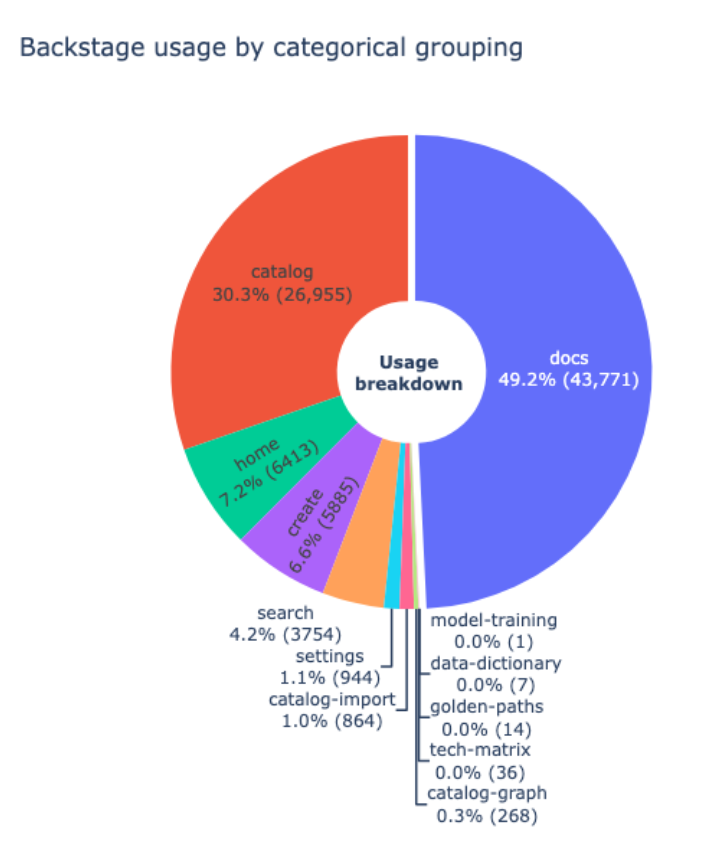

In [ ]:
# Use one-hot encoding to break out the 'category' categorical column for subsequent processing
df_encoded = pd.get_dummies(df, columns=['category', ])

## Catalog data analysis

In [ ]:
df_catalog = df_encoded[df_encoded['category_catalog']==True]

catalog_cat_list = []
catalog_subcat_list = []

def process_catalog_url(catalog_url_column):
    for catalog_item in catalog_url_column:
        if catalog_item == '/catalog' or catalog_item == '/catalog/default' or catalog_item == '/catalog/default/':
            cat_category = 'catalog_home'
            cat_subcategory = None
        else:
            if '/catalog/default/' in catalog_item:
                base_cat = catalog_item.split('/catalog/default/')[1].split('/')
                if len(base_cat) == 3:
                    cat_category = base_cat[0]
                    cat_subcategory = base_cat[2]
                elif len(base_cat) == 2:
                    cat_category = base_cat[0]
                    cat_subcategory = None
            elif '/catalog/kafka/' in catalog_item:
                base_cat = catalog_item.split('/catalog/kafka/')[1].split('/')
                if len(base_cat) == 3:
                    cat_category = base_cat[0]
                    cat_subcategory = base_cat[2]
                elif len(base_cat) == 2:
                    cat_category = base_cat[0]
                    cat_subcategory = None               

        catalog_cat_list.append(cat_category)
        catalog_subcat_list.append(cat_subcategory)
    
    return catalog_cat_list,catalog_subcat_list

df_catalog['catalog_category'],df_catalog['catalog_subcategory'] = process_catalog_url(df_catalog['url'])

### Weekly code insights data

In [ ]:
df_catalog_codeinsights = df_catalog[df_catalog['catalog_subcategory']=='scorecard']

In [ ]:
cat_group = (
    df_catalog_codeinsights.groupby(["Week", "catalog_category"])
    .agg(
        n_count=pd.NamedAgg("timestamp", "count"),
    )
    .reset_index(drop=False)
)

cat_group.sort_values(by=['Week'], inplace=True, ascending=True)

cat_group.head(10)

In [ ]:
fig = go.Figure()

s0=cat_group[cat_group['catalog_category']=='component']
s1=cat_group[cat_group['catalog_category']=='group']
s2=cat_group[cat_group['catalog_category']=='system']

fig.add_trace(go.Bar(x=s0['Week'], y = s0['n_count'], name='component', marker_color='cornflowerblue', text=s0['n_count']))
fig.add_trace(go.Bar(x=s1['Week'], y = s1['n_count'], name='group', marker_color='lemonchiffon', text=s1['n_count']))
fig.add_trace(go.Bar(x=s2['Week'], y = s2['n_count'], name='system', marker_color='lightblue', text=s2['n_count']))

fig.update_layout(
    width=850, height=500,
    title='Code insights unique weekly views by catalog type',
    plot_bgcolor="white",
    font=dict(size=7),
    barmode='stack',
    xaxis=dict(showticklabels=True),
)

fig.show()

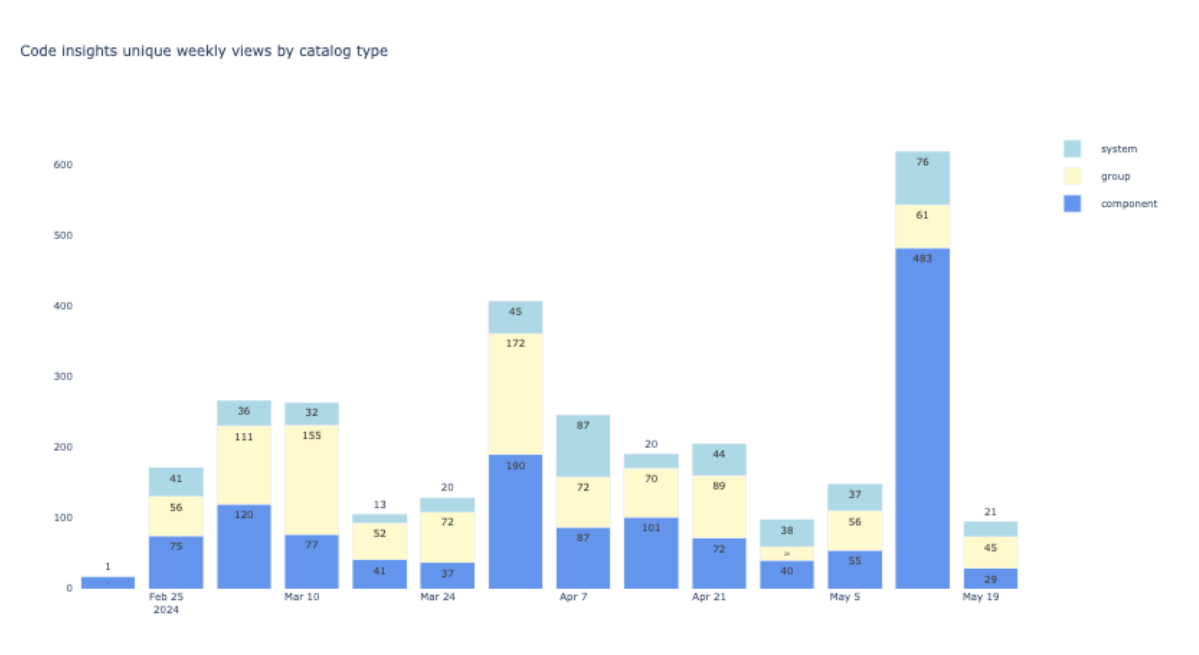

## Search data analysis

In [ ]:
df_search = df_encoded[df_encoded['category_search']==True]
top20_searches = df_search['url_query'].value_counts().reset_index().head(20)
top20_searches


In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=top20_searches["url_query"],
        y=top20_searches["count"],
        text=top20_searches["count"],
        textposition="outside",
        texttemplate="%{text}",
        # This is all you need to do to make it a row chart
        # orientation="h",
    )
)
fig.update_layout(
    width=1000, height=500,
    title='Top 20 Backstage searches',
    plot_bgcolor="white",
    xaxis=dict(showticklabels=True),
    # Ensure the correct sorting
    # yaxis={'categoryorder':'total ascending'},
)

fig.show()

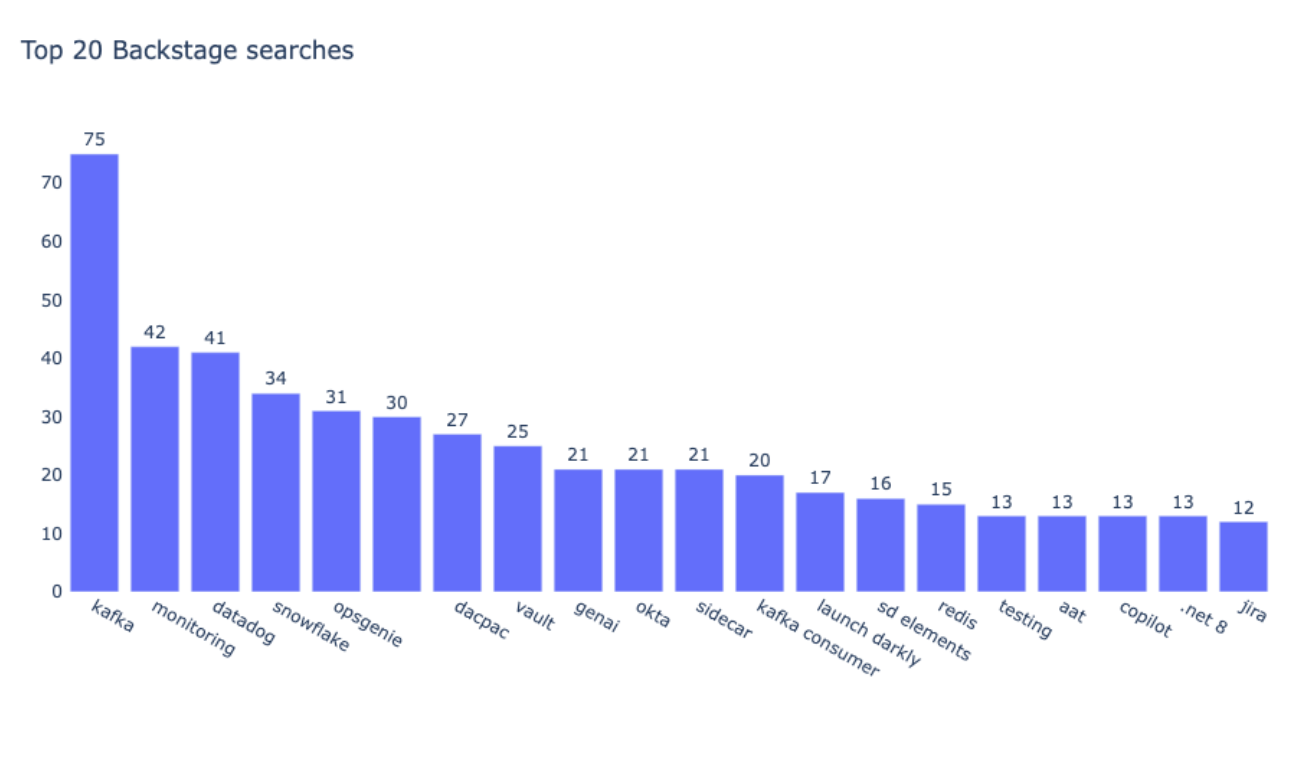

## Docs data analysis

In [ ]:
df_docs = df_encoded[df_encoded['category_docs']==True]

In [ ]:
doc_category_list = []
doc_category_sublist = []

def parse_doc_url(column):
    for url_item in column:

        if url_item == '/docs':
            cat = 'docs_homepage'
            cat_sub = 'docs_homepage'
        elif url_item == '/docs/default':
            cat = 'docs_default'
            cat_sub = 'docs_default'
        else:
            cat = url_item.split('/')[3].lower()
            if len(url_item.split('/')) == 4:
                cat_sub = url_item.split('/')[3].lower()
            else:
                cat_sub = url_item.split('/')[4].lower()

        doc_category_list.append(cat)
        doc_category_sublist.append(cat_sub)

    return doc_category_list, doc_category_sublist

In [ ]:
df_docs['doc_category'], df_docs['doc_category_sublist'] = parse_doc_url(df_docs['url'])

In [ ]:
docs_group = (
    df_docs.groupby(["doc_category",'doc_category_sublist'])
    .agg(
        n_count=pd.NamedAgg("timestamp", "count"),
    )
    .reset_index(drop=False)
)

# docs_group.sort_values(by=["doc_category",'doc_category_sublist', 'n_count'], inplace=True, ascending=[True,True,False])

docs_group.sort_values(by=['n_count'], inplace=True, ascending=False)

top20_docs = docs_group.head(20)
top20_docs

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=top20_docs["doc_category_sublist"],
        y=top20_docs["n_count"],
        text=top20_docs["n_count"],
        textposition="outside",
        texttemplate="%{text}",
    )
)
fig.update_layout(
    width=1000, height=500,
    title='Top 20 Backstage doc subcategories visited',
    plot_bgcolor="white",
    xaxis=dict(showticklabels=True),
)

fig.show()

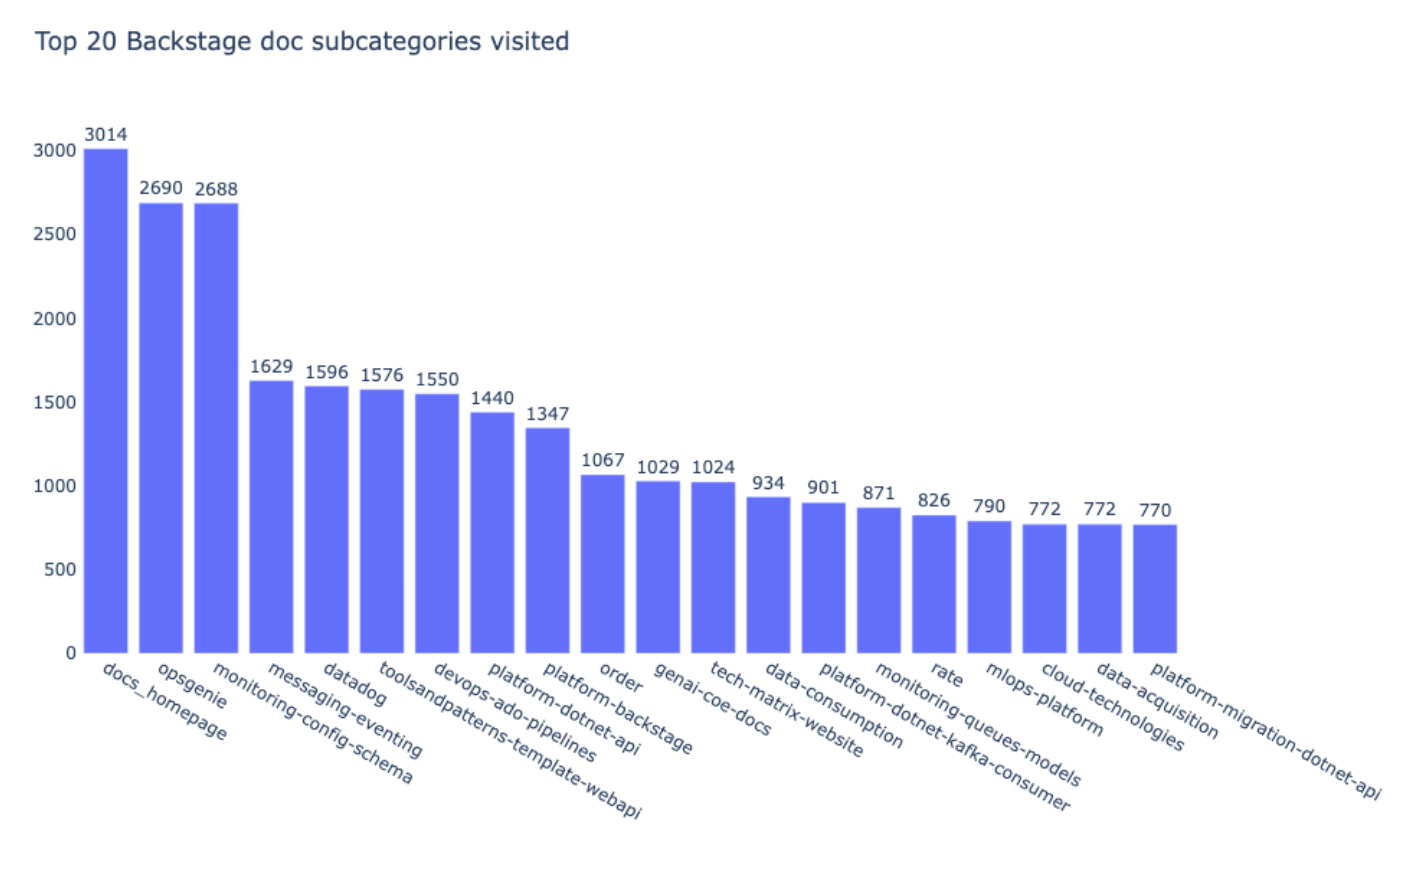